In [82]:

import numpy as np
import astropy.units as u
import poppy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

import lina

wavelength = 633*u.nm

pupil_diam = 6.75*u.mm

dm_diam = 10.2*u.mm
dm_pupil_diam = 9.5*u.mm
dm_fill_factor = (dm_pupil_diam/dm_pupil_diam).decompose().value

lyot_pupil_diam = 9.5*u.mm
lyot_stop_diam = 8.6*u.mm
fl = 300*u.mm

um_per_lamD = (wavelength * fl/lyot_stop_diam).to(u.um)
psf_pixelscale = 3.76*u.um/u.pix
psf_pixelscale_lamD = (psf_pixelscale/um_per_lamD).value
lyot_stop_ratio = (lyot_stop_diam/lyot_pupil_diam).decompose().value

psf_pixelscale_lamD, um_per_lamD

(0.17027909426013688, <Quantity 22.08139535 um>)

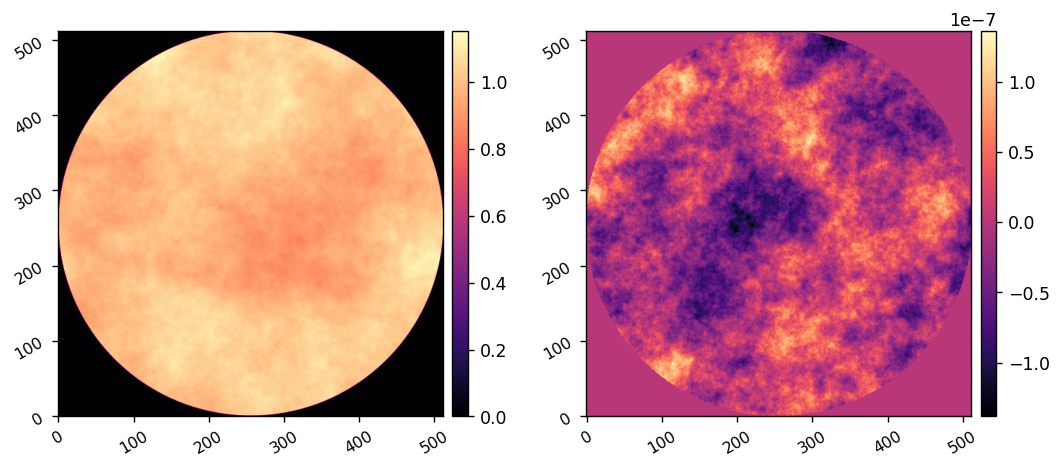

array(4.e-08)

In [91]:
reload(utils)
wfe, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=40*u.nm, amp_rms=0.05,
                                remove_modes=3)

wfe_amp = xp.abs(wfe)
wfe_opd = xp.angle(wfe)*wavelength.to_value(u.m)/2/np.pi
imshow2(wfe_amp, wfe_opd, )
lina.utils.rms(wfe_opd[mask])


In [97]:
model.npsf

200

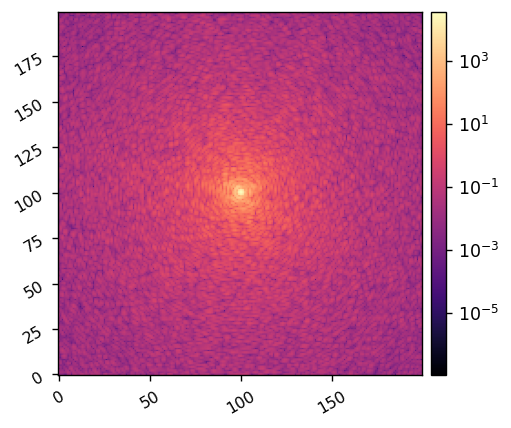

In [108]:
npix = 512
npsf = 200

fnum = 100/8.6
pix_m = 3.76e-6
q = wavelength.to_value(u.m) *  fnum/ pix_m
ppx = (xp.linspace(-(npix-1)/2.0, (npix-1)/2.0, num=npix) - 0.5) / npix
# fpx = (xp.linspace(-(npix-1)/2.0, (npix-1)/2.0, num=npix) - 0.5) / q
fpx = (xp.linspace(-(npsf-1)/2.0, (npsf-1)/2.0, num=npsf) - 0.5) / q

def make_mft_matrices(focal_coord, pupil_coord, norm_factor=1):
    vy = xp.outer(focal_coord, pupil_coord)
    xu = xp.outer(pupil_coord, focal_coord)
    
    # check me
    norm = xp.sqrt(len(pupil_coord) * norm_factor)
    My = xp.exp(-1j*2*np.pi*vy) / norm 
    Mx = xp.exp(-1j*2*np.pi*xu) / norm
    
    return Mx, My

def get_fresnel_TF(dz, N, wavelength, fnum):
    '''
    Get the Fresnel transfer function for a shift dz from focus
    '''
    df = 1.0 / (N * wavelength * fnum)
    rp = get_scaled_coords(N, df, shift=False)[-1]
    return xp.exp(-1j*np.pi*dz*wavelength*(rp**2))

def get_scaled_coords(N, scale, center=True, shift=True):
    if center:
        cen = (N-1)/2.0
    else:
        cen = 0
        
    if shift:
        shiftfunc = xp.fft.fftshift
    else:
        shiftfunc = lambda x: x
    cy, cx = (shiftfunc(xp.indices((N,N))) - cen) * scale
    r = xp.sqrt(cy**2 + cx**2)
    return [cy, cx, r]

defocus = 0.9e-3
get_fresnel_TF(defocus, npix, wavelength.to_value(u.m), fnum)

Mx, My = make_mft_matrices(fpx, ppx, q)

image = xp.abs(Mx.T@wfe@My.T)**2

imshow1(image, lognorm=True)


Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


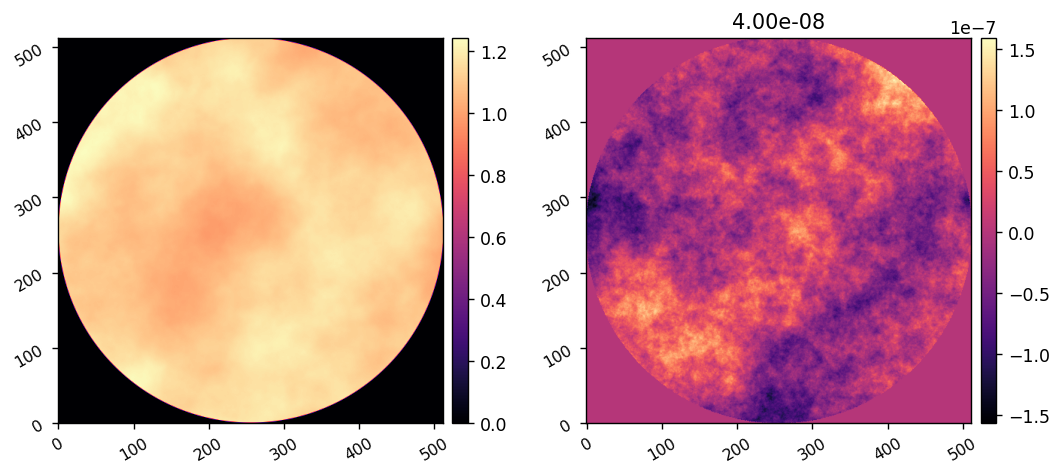

In [78]:
reload(cscoob)
reload(dm)

npix = 512
oversample = 16

model = cscoob.SCOOB(npix=npix, oversample=oversample, 
                     psf_pixelscale_lamD=psf_pixelscale_lamD)

wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=model.npix, oversample=1)
model.APERTURE = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(wf)

wfe, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_seed=123, amp_seed=1234,
                                opd_index=2.75, amp_index=4,
                                opd_rms=40*u.nm, amp_rms=0.05,
                                remove_modes=50)

wfe_amp = xp.abs(wfe)
wfe_opd = xp.angle(wfe)*wavelength.to_value(u.m)/2/np.pi
imshow2(wfe_amp, wfe_opd, '', f'{lina.utils.rms(wfe_opd[mask]):.2e}')

model.WFE = wfe

VORTEX = cscoob.make_vortex_phase_mask(model.make_grid(which='fpm', polar=True), charge=6, 
                                    #    singularity=20*u.um, 
                                       focal_length=500*u.mm, pupil_diam=model.dm_pupil_diam, wavelength=632.8*u.nm)

model.LYOT = poppy.CircularAperture(radius=0.9*pupil_diam/2).get_transmission(wf)
# imshow3(model.APERTURE, model.LYOT, xp.angle(VORTEX), npix2=model.npix)

In [36]:
model.WFE

In [30]:
model.reset_dm()

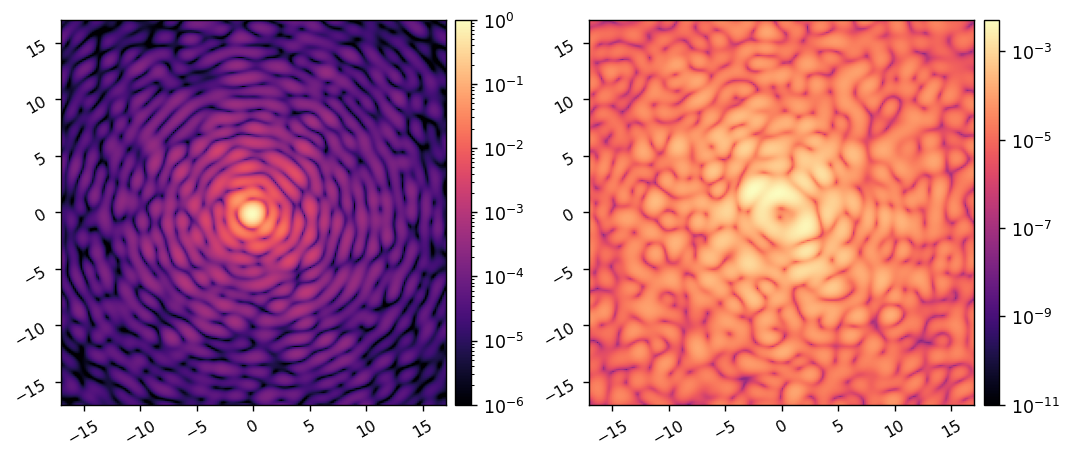

In [81]:
model.npsf = 200
model.FPM = None

model.reset_dm()

model.Imax_ref = None
ref_unocc_psf = model.snap()

model.Imax_ref = xp.max(ref_unocc_psf)
ni_psf = model.snap()

model.FPM = VORTEX

model.FIELDSTOP = None
# model.FIELDSTOP = model.focal_grid_pol[0]<15

ref_im = model.snap()

imshow2(ni_psf, ref_im, 
        pxscl=model.psf_pixelscale_lamD,
        vmin1=1e-6, vmin2=1e-11, lognorm=True)

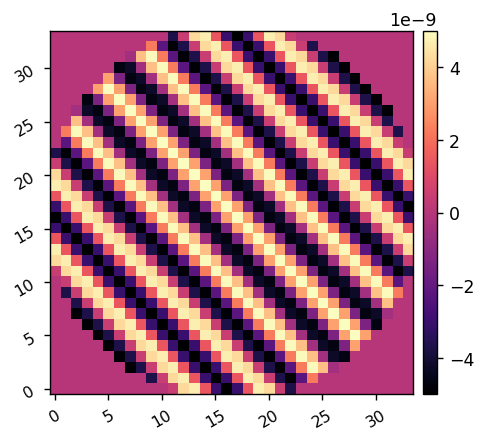

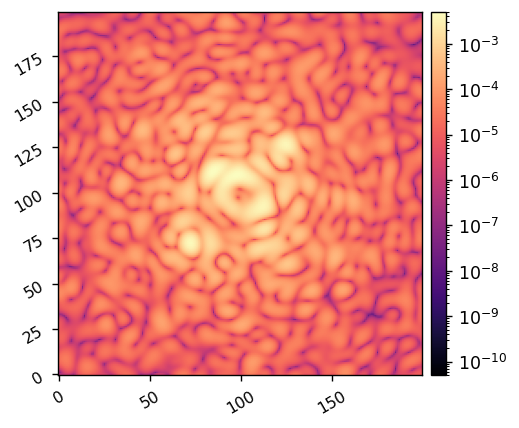

In [80]:
Nact = 34
xpp = xp.arange(-Nact//2, Nact//2) + 1/2
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-9
separation = 5
command = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/Nact)*model.dm_mask

imshow1(command)
model.set_dm(command)

im = model.snap()
imshow1(im, lognorm=True)

model.reset_dm()